After DigitalSreeni's U-net tutorial: https://youtu.be/azM57JuQpQI
Training data set can be found here : https://www.kaggle.com/c/data-science-bowl-2018/data
Using TensorFlow Keras

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
# Input images size
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Input paths
PARENT_DIR = './data-science-bowl-2018/'
TRAIN_PATH ='stage1_train/'
TEST_PATH='stage1_test/'

#consistent randomness and good-luck charm
seed = 42
np.random.seed = seed

Importing the data

In [3]:
# [1] offers the child of the specified path in the tuple
train_ids = next(os.walk(PARENT_DIR + TRAIN_PATH))[1]
test_ids = next(os.walk(PARENT_DIR + TEST_PATH))[1]

Defining the train and control set +  Pre-processing the train data to fit into our U-net

In [4]:
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, 1), dtype = np.bool)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    #Actual train image
    path = PARENT_DIR + TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_train[n] = img
    #Control mask, merge all images of individual cells in a single one containing all labeled cells
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(path +'/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True),
                              axis = -1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [03:24<00:00,  3.28it/s]


Reading and resizing the test set

In [5]:
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
sizes_test =[]

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    #Actual train image
    path = PARENT_DIR + TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 60.09it/s]


Printing a random sample from the processed data, control and original

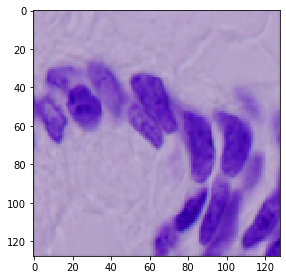

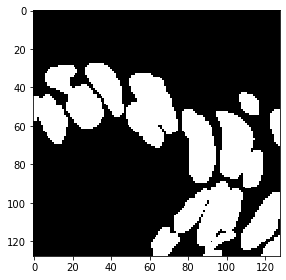

In [6]:
image_we = random.randint(0, len(train_ids))
#original
imshow(X_train[image_we])
plt.show()
#control
imshow(np.squeeze(Y_train[image_we]))
plt.show()


Model creation after U-net diagram (I need to find out how to import an image here :) )

In [7]:
# Input layer
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

In [8]:
# Converts pixel value to float, and normalizes it
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

First convolutional layers, size = 16 of  (3x3) convolutional kernels 
                                          -initializing them with 'he_normal' kernel_initializer
                                          
After each convolution we drop out some of output's data to reduce/prevent overfitting
MaxPooling is user to 'contract' the input reducing its size and combating overfitting

In [9]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [10]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [11]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [12]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

In [13]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c5)

From this point we should start the expansion path of the processed data
    Before further processing of the expanded data, we concatenate its with the previous layer 

In [14]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c6)


In [15]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c7)


In [16]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c8)


In [17]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c9)


In [18]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

Checkpoints, just in case

In [19]:
#Model checkoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose = 1, save_best_only = True )

We send callbacks for aditional control:
    EarlyStopping if the monitor does not improve over "patience" epochs
    TensorBoard is a visualization tool saved in log_dir inside parent directory

In [20]:
#Callbacks
callbacks =[
   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
   tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [22]:
results = model.fit(X_train,Y_train,validation_split=0.1, batch_size = 16, epochs = 25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 36s 958ms/step - loss: 2.5125 - accuracy: 0.7400 - val_loss: 0.8170 - val_accuracy: 0.8513
Epoch 2/25
38/38 [==============================] - 3s 90ms/step - loss: 0.4751 - accuracy: 0.8537 - val_loss: 0.3152 - val_accuracy: 0.8936
Epoch 3/25
38/38 [==============================] - 3s 90ms/step - loss: 0.3001 - accuracy: 0.8808 - val_loss: 0.2994 - val_accuracy: 0.8923
Epoch 4/25
38/38 [==============================] - 3s 91ms/step - loss: 0.2433 - accuracy: 0.8973 - val_loss: 0.2189 - val_accuracy: 0.9228
Epoch 5/25
38/38 [==============================] - 3s 91ms/step - loss: 0.2054 - accuracy: 0.9162 - val_loss: 0.1874 - val_accuracy: 0.9301
Epoch 6/25
38/38 [==============================] - 3s 92ms/step - loss: 0.1845 - accuracy: 0.9258 - val_loss: 0.1674 - val_accuracy: 0.9361
Epoch 7/25
38/38 [==============================] - 3s 91ms/step - loss: 0.1727 - accuracy: 0.9322 - val_loss: 0.1560 - val_accuracy: 0.9385
Epoch 8/25


Testing the model

In [24]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose = 1)

#Binarizationing the results
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 18ms/step


Printing some results

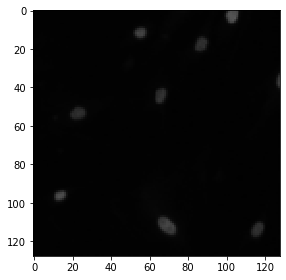

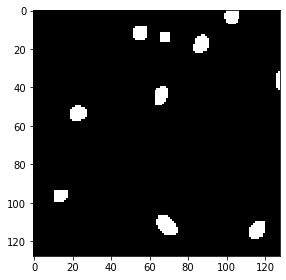

/home/tudor/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


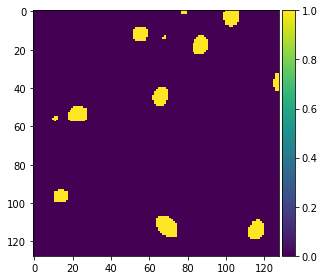

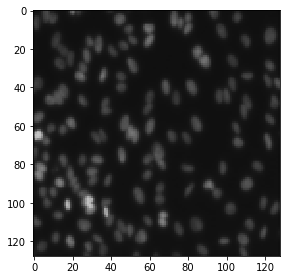

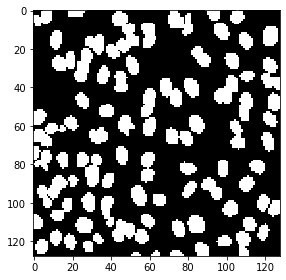

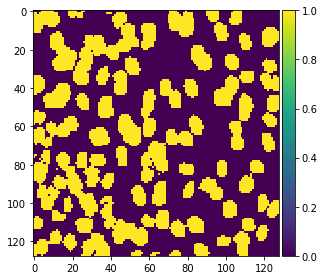

In [26]:
#random training sample
i = random.randint(0, len(preds_train_t))
imshow(X_train[i])
plt.show()
imshow(np.squeeze(Y_train[i]))
plt.show()
imshow(np.squeeze(preds_train_t[i]))
plt.show()

#random validation sample
i = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][i])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][i]))
plt.show()
imshow(np.squeeze(preds_val_t[i]))
plt.show()
